# TD($\lambda$): Weighted Average over N-Steps

So we have taken a look at [TD(N)](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Free%20Learning/td_n.ipynb) as an alterative method to estimating our TD-Targets for Q-Learning (although we could have also estimated the Values if we wanted). The main problem can basically be boiled down to how much data we want to leverage to update our model. In standard Q-Learning, we update every step, using bootstrapped estimates for our target. Monte Carlo uses full trajectories to estimate its targets. Both are on the extreme ends, and so TD(N) is an N-Step method where we estimate our target with a shorter N-Step Trajectory which is longer than just 1 step, but shorter than the full trajectories!

### Computing our Returns $G_t$

##### Monte Carlo

In Monte Carlo we use the full trajectory of returns. Lets say our trajectory is T steps long:

$$G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + ... + \gamma^{T-t-1}r_T$$

##### TD(N)

Similarly in TD(N) we do the same thing, but we only keep the first $N$ steps, and then bootstrap estimate all future estimates:

$$G_t^{(n)} = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + ... + \gamma^{n}V(s_{t+n})$$

### Blending N-Step Estimates

The problem with our TD(N) is that we have to select N, which can be a tough hyperparameter to tune and greatly problem dependent! Therefore, what if we could avoid this all together? The goal is then to average together all possible n-step returns. But intuitively, it would make sense not to just do a some basic average, but rather some decaying weighted average that allows us to control the contribution of each state. We could write something like this:

$$G_t^\lambda = \sum_{n=1}^\infty \lambda^{n-1}G_t^{(n)}$$

Where $\lambda$ is some hyperparameter we can pick between $[0,1]$, and controls our short vs long term trajectory tradeoff. Larger $\lambda$ values will decay slower, therefore putting more emphasis on longer trajectories and vice versa!

But one small problem. Although we are doing exponential weighted sum of $G_t^{(n)}$, we would ideally have all the weights sum to 1 so it is a weighted average. Well, what are the sum of our weights?

$$\sum_{n=1}^\infty \lambda^{n-1} = \sum_{n=0}^\infty \lambda^{n} = \frac{1}{1-\lambda}$$

If our weights all sum to $\frac{1}{1-\lambda}$, then we can multiply by its reciprocal so all our weights add to 1! Therefore our final form is:

$$G_t^\lambda = (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1}G_t^{(n)}$$

## Lets Implement It!

This is very similar to before in our TD(N), but there are a few key changed:

1) Explore a Full Episode First
2) For each timestep t, compute $G_t^\lambda$
3) Perform an update for each state that was visited


In [19]:
import numpy as np
from tqdm.notebook import tqdm
import gymnasium as gym

def epsilon_greedy(Q, state, epsilon, env):
    if np.random.rand() < epsilon:
        return env.action_space.sample() 
    else:
        return np.argmax(Q[state])


def lambda_q_learning(env, 
                      lambda_weight=0.9,
                      num_episodes=25000, 
                      alpha=0.01, 
                      gamma=0.98, 
                      epsilon=0.1):

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []

    print("Num Episodes:", num_episodes)
    for episode in tqdm(range(num_episodes)):
        
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon, env)
        total_reward = 0
        
        states = []
        actions = []
        rewards = []
        
        done = False
        while not done:

            next_state, reward, terminal, truncated, _ = env.step(action)
            done = terminal or truncated

            next_action = epsilon_greedy(Q, next_state, epsilon, env)

            ### Store Experience ###
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            ### Accumulate Reward for Logging ###
            total_reward += reward

            ### Set our next state and action ###
            state, action = next_state, next_action

        ### Store the Total Rewards ###
        episode_rewards.append(total_reward)
    
        ### Compute the TD Lambda Returns ###
        T = len(states)

        print("T:", T)
        for t in tqdm(range(T)):

            ### Initialize G and Lambda ###
            G_lambda = 0
            lambda_weights = 1            

            ### For every sequence from 1 to t compute the N step Return ###
            ### If T = 5 then we are doing:
            ### n: 1 -> 5
            ### n: 1 -> 4
            ### n: 1 -> 3 
            ### ...
            ### we have a +1 because range is not right inclusive
            print("n:", T-t+1)
            for n in tqdm(range(1, T-t+1)):
                G_n = sum([gamma**i * rewards[t + i] for i in range(n)])

                ### If our partial trajectory of n steps from t doesnt include the last state T ###
                ### then we can use our bootstrapped estiamte for future rewards just like normal! ###
                if t + n < T:
                    G_n += gamma**n * np.max(Q[states[t+n]])

                ### Compute our Weights (exponential) ###
                weight = (1 - lambda_weight) * (lambda_weight**(n-1))

                ### Add it Up ###
                G_lambda += G_n * weight

                ### RETURN JUST TO EXIT THIS IS TOO SLOW ANYWAY!! ###
                return

        ### Update our Q Value for the current state ###
        Q[states[t], actions[t]] += alpha * (G_lambda - Q[states[t], actions[t]])
            
    return Q, episode_rewards
    

### Lets Train a Model!

Now that we have our setup, lets train a model to see if it works!

In [20]:
def test_policy(policy, env, num_episodes=100):

    total_rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0

        while not done:
            action = policy[state]
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward

        total_rewards.append(ep_reward)

    success_rate = np.mean([1 if r > -100 else 0 for r in total_rewards])
    print(f"Success Rate: {success_rate * 100:.2f}%")
    return success_rate

env = gym.make('CliffWalking-v0')
lambda_q_learning(env)
    

Num Episodes: 25000


  0%|          | 0/25000 [00:00<?, ?it/s]

T: 267261


  0%|          | 0/267261 [00:00<?, ?it/s]

n: 267262


  0%|          | 0/267261 [00:00<?, ?it/s]

### Too Slow?

Although this is conceptually correct, we cannot run this! This is because we have to, for every trajectory, loop through **ALL POSSIBLE N-STEPS** for **ALL TIMESTEPS**. Unless you are working on a tiny environment, this is infeasible. The other problem is, in this implementation, we have to complete an **ENTIRE TRAJECTORY** before we can do anything, so we have similar problems to Monte Carlo again!

So is there a way to do this quicker?

### Eligibility Traces 

An eligibility trace is a table tell us two things:

1) Frequency of a state
2) Recency of a state

Here is the setup for the Eligibility Trace and then we will show its equivalence to the previous (slower) method. Now again, we could be doing this for our Q values (so we have to track both state and actions) or we could have just done values (track only states). 

First we initialize our trace $e(s,a)$ as all 0 for all states. 

$$e_t(s,a) = \gamma\lambda e_{t-1}(s,a) + \mathbb{1}_{S_t=s, A_t=a}$$

- $\gamma$ is our discount factor
- $\lambda$ is our parameter for TD($\lambda$)
- $\mathbb{1}_{S_t=s}$ is an identity function that adds 1 to the current state $s$ and 0 to everything else!

Then when we want to update our Values we can first find our final TD-Error at time $t$:

$$\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$$

And then update our Q table with with this $\delta$ weighted by our past history stored in $e(s)$
$$Q(s,a) = Q(s,a) + \alpha\delta_t e_t(s,a)$$

#### What Does the Decay Look Like?

Lets pretend we play a game that 20 timesteps long, and we visit the state A the first 5 timesteps, then at timestep 10 and then again at timestep 15

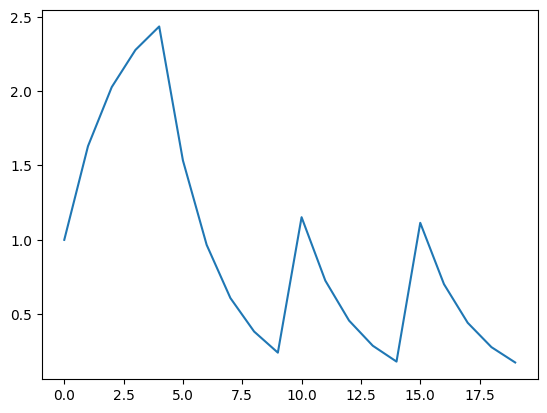

In [35]:
import matplotlib.pyplot as plt

gamma = 0.9
lambda_weights = 0.7

e_A = 0
et_A = []
for i in range(20):
    if i in list(range(0,5)) + [10,15]:
        e_A = gamma * lambda_weights * e_A + 1
        et_A.append(e_A)
    else:
        e_A = gamma * lambda_weights * e_A
        et_A.append(e_A)

plt.plot(et_A)

Notice how our weights increase when we visit and then we have an exponential decay for all other times! Isn't this exactly what we wanted? We want to decay the future timesteps by our $\lambda$ parameter to control our short vs long term returns.

Now lets prove the equivalence of the previous method (known as the **FORWARD VIEW**) and this method with the eligibility trace as the **BACKWARD VIEW**. This proof can be found in the [Sutton & Barto](http://incompleteideas.net/book/ebook/node76.html) book in their exploration of this same topic!

#### Step 1: Get the Explicit Form of the Eligibility Trace

Right now we have this recursive form:

$$e_t(s,a) = \gamma\lambda e_{t-1}(s,a) + \mathbb{1}_{S_t=s, A_t=a}$$

Lets see if we can manipulate it a bit so we no longer have the recursion. To do this we can first unroll this a bit to find the pattern. And for simplicity I will just do it for the state $s$ rather than state/action pairs (although nothing would change if we did)


$$e_t(s) = \gamma\lambda e_{t-1}(s) + \mathbb{1}_{S_t=s}$$
$$e_{t-1}(s) = \gamma\lambda e_{t-2}(s) + \mathbb{1}_{S_{t-1}=s}$$
$$e_{t-2}(s) = \gamma\lambda e_{t-3}(s) + \mathbb{1}_{S_{t-2}=s}$$

Lets now plug one into other:

$$e_t(s) = \gamma\lambda \left(\gamma\lambda e_{t-2}(s) + \mathbb{1}_{S_{t-1}=s}\right)+ \mathbb{1}_{S_t=s}$$
$$= (\gamma\lambda)^2 e_{t-2}(s) + \gamma\lambda\mathbb{1}_{S_{t-1}=s}+ \mathbb{1}_{S_t=s}$$
$$= (\gamma\lambda)^2 \left(\gamma\lambda e_{t-3}(s) + \mathbb{1}_{S_{t-2}=s}\right) + \gamma\lambda\mathbb{1}_{S_{t-1}=s}+ \mathbb{1}_{S_t=s}$$
$$= (\gamma\lambda)^3 e_{t-3}(s) + (\gamma\lambda)^2\mathbb{1}_{S_{t-2}=s} + \gamma\lambda\mathbb{1}_{S_{t-1}=s}+ \mathbb{1}_{S_t=s}$$

if our total sequence was $t$ long, then we can unroll $t$ times until $t=0$. We can see the pattern now, its our weighted eligibility term for a state plus a decayed sequence of indicator functions!

$$e_t(s) = (\gamma\lambda)^t e_0(s) + \sum_{k=0}^t(\gamma\lambda)^{t-k}\mathbb{1}_{S_{k}=s}$$

And also, $e_0(s)$ was initialized as 0, so the first term dissapears and we end up with our final (non-recursive) form!:

$$e_t(s) = \sum_{k=0}^t(\gamma\lambda)^{t-k}\mathbb{1}_{S_{k}=s}$$

#### Step 2: What was the TD Error?

Remember, our update always looks like this:

$$V(S_t) = V(S_t) + \alpha (G_t^\lambda - V(S_t))$$

because we want to move our Values in the direction of the TD-Target $G_t^\lambda$. This means our change to $V(S_t)$ can be written simply as $\Delta V(s)$

Lets create two of these updates, one for the foward and one for the backward. I will use the same notation as the book so its consistent!

- Let $\Delta V_t^\lambda(s_t)$ be our Forward method update at time $t$ of $V(s_t)$
- Let $\Delta V_t^{TD}(s)$ be our Backward method update at time $t$ of state $s$

The goal is to show equivalence between these two, that the accumulated updates over a full trajectory is the same! So we want to show:

$$\sum_{t=0}^{T-1}\Delta V_t^{TD}(s) = \sum_{t=0}^{T-1}\Delta V_t^\lambda(s_t)\mathbb{1}_{S_{t}=s}$$

The reason we multiply by the indicator function $\mathbb{1}_{S_{t}=s}$ is because in our Forward method, we only add to the state that we are referencing, so its just a quick check. In our Backward method, we are already doing that inside the Eligibility Trace so the indicator is contained!

#### Step 3: Expand the Left Side

Lets start with the left side:

$$\sum_{t=0}^{T-1}\Delta V_t^{TD}(s)$$

We already found earlier we have a non-recursive form for our Eligibility Trace update:

$$e_t(s) = \sum_{k=0}^t(\gamma\lambda)^{t-k}\mathbb{1}_{S_{k}=s}$$

and we also know the update rule for our Values are:

$$V(s) = V(s) + \alpha\delta_t e_t(s)$$

which implies:

$$\Delta V(s) = \alpha\delta_t e_t(s)$$

So lets use this expression for our $\Delta V_t^{TD}(s)$ as that is the one using this Eligibility Trace:

$$\sum_{t=0}^{T-1}\Delta V_t^{TD}(s)$$
$$= \sum_{t=0}^{T-1} \alpha\delta_t e_t(s)$$

And we can now plug in our new form for $e_t(s)$:

$$= \sum_{t=0}^{T-1} \alpha\delta_t \sum_{k=0}^t(\gamma\lambda)^{t-k}\mathbb{1}_{S_{k}=s}$$

To better understand the variables we have:

- $t$ is the time index of the TD error
- $k$ is the time index for the past occurrence of some state $s$

So it is reasonable to say that our valid region of $t$ and $k$ is:

$$0 \leq k \leq t \leq T-1$$

In which case we can update the limits of the summation to the valid regions:

$$= \sum_{t=k}^{T-1} \alpha\delta_t \sum_{k=0}^t(\gamma\lambda)^{t-k}\mathbb{1}_{S_{k}=s}$$

But this seems weird right? We have a circular dependency. Our limits of the outer sum depends on the inner sum! This obviously doesn't work, so we need to swap the summation order before we do this:

$$\sum_{t=0}^{T-1}\sum_{k=0}^t \rightarrow \sum_{k=0}^{T-1}\sum_{t=k}^{T-1}$$

This is a valid swap as $k$ can go anywhere between $0 \rightarrow T-1$, and $t$ starts at $k$. But now that we swapped these two we need to make sure our $\delta_t$ goes into the inner sum:

$$= \sum_{k=0}^{T-1} \alpha \sum_{t=k}^{T-1}(\gamma\lambda)^{t-k}\mathbb{1}_{S_{k}=s}\delta_t$$

We can then reorganize this by pulling our indicator out of the inner sum:

$$= \sum_{k=0}^{T-1} \alpha \mathbb{1}_{S_{k}=s} \sum_{t=k}^{T-1}(\gamma\lambda)^{t-k}\delta_t$$

Lastly, $t$ and $k$ are just dummy variables, so we can technically just swap them (variable substituion). Lets do that, so we get $t$ again as our outside sum:

$$= \sum_{t=0}^{T-1} \alpha \mathbb{1}_{S_{t}=s} \sum_{k=t}^{T-1}(\gamma\lambda)^{k-t}\delta_t$$

#### Step 4: Expand the Right Side

Lets take our right side and expand it out. First lets just start with $\Delta V_t^\lambda(s_t)$

Remember again that:

$$V(S_t) = V(S_t) + \alpha (G_t^\lambda - V(S_t))$$

or

$$\Delta V(S_t) = \alpha (G_t^\lambda - V(S_t))$$

This means:

$$\frac{1}{\alpha} \Delta V(S_t) = G_t^\lambda - V(S_t) $$

and we already have our forward view:

$$G_t^\lambda = (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1}G_t^{(n)}$$

so lets plug it in!

$$\frac{1}{\alpha} \Delta V(S_t) = - V(S_t) + (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1}G_t^{(n)}$$

\begin{aligned}
\frac{1}{\alpha} \Delta V(S_t) & =- V(S_t) + (1-\lambda) \lambda^0 \left[R_{t+1} + \gamma V_t(S_{t+1})\right] \\
& + (1-\lambda) \lambda^0 \left[R_{t+1} + \gamma V_t(S_{t+1})\right] \\
& + (1-\lambda) \lambda^1 \left[R_{t+1} + \gamma V_t(S_{t+1}) + \gamma^2 V_t(S_{t+2})\right] \\
& + (1-\lambda) \lambda^2 \left[R_{t+1} + \gamma V_t(S_{t+1}) + \gamma^2 V_t(S_{t+2}) + \gamma^3 V_t(S_{t+3})\right] \\
& + \ldots
\end{aligned}

As we can see, its the weighted sum of all of our different N-Step returns (just like we discribed in our Forward method). Now if you remember, we made our weights intentonally sum upto 1 before (thus the extra $(1-\lambda)$ term) that will be helpful for us now!

My latex ability isnt that good, so I am just going to hand write this algebraic manipulation here!

![image](src/algb_manip.png)

Our final expression from this manipulation is then:

\begin{aligned}
\frac{1}{\alpha} \Delta V(S_t) & =- V(S_t) \\
& + (\lambda\gamma)^0 \left[R_{t+1} + \gamma V(S_{t+1}) - \gamma\lambda V(S_{t+1})\right] \\
& + (\lambda\gamma)^1 \left[R_{t+2} + \gamma V(S_{t+2}) - \gamma\lambda V(S_{t+2})\right] \\
& + (\lambda\gamma)^2 \left[R_{t+3} + \gamma V(S_{t+3}) - \gamma\lambda V(S_{t+3})\right] \\
& + \ldots
\end{aligned}

Now lets do our final manipulation, lets take the first row and merge in our $-V(S_t)$

$$- V(S_t) + (\lambda\gamma)^0 \left[R_{t+1} + \gamma V(S_{t+1}) - \gamma\lambda V(S_{t+1})\right]$$
$$= - V(S_t) + R_{t+1} + \gamma V(S_{t+1}) - \gamma\lambda V(S_{t+1})$$
$$= R_{t+1} + \gamma V(S_{t+1}) - V(S_t) - \gamma\lambda V(S_{t+1})$$

Wait, we now have $R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$. That is subtracting our future returns from our current value. Isn't that exactly our TD Error? Yes! Remember earlier we called:

$$\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$$

Therefore we have pulled in our $\delta_t$ and we can rewrite this as:

$$= \delta_t - \gamma\lambda V(S_{t+1})$$

Now lets add in our next line:

$$\delta_t - \gamma\lambda V(S_{t+1})+ (\lambda\gamma)^1 \left[R_{t+2} + \gamma V(S_{t+2}) - \gamma\lambda V(S_{t+2})\right]$$
$$= \delta_t + (\lambda\gamma) \left[R_{t+2} + \gamma V(S_{t+2} - V(S_{t+1}))\right] - (\gamma\lambda)^2 V(S_{t+2})$$
$$= \delta_t + (\lambda\gamma) \delta_{t+1} - (\gamma\lambda)^2 V(S_{t+2})$$

So we now have our next step in and we are starting to see a pattern. Lets do one more!
$$\delta_t + (\lambda\gamma) \delta_{t+1} + (\lambda\gamma)^2 \left[R_{t+3} + \gamma V(S_{t+3})- V(S_{t+2}))\right] - (\gamma\lambda)^3V(S_{t+3})$$
$$= \delta_t + (\lambda\gamma) \delta_{t+1} + (\lambda\gamma)^2 \delta_{t+2} - (\gamma\lambda)^3V(S_{t+3})$$

As you can see, we basically have a weighted sum of our TD errors! Therefore, we can write our expression as:

$$\frac{1}{\alpha} \Delta V^\lambda(S_t) = \sum_{k=t}^{T-1}(\lambda\gamma)^{k-t}\delta_k$$

Remember, our left side was originally:

$$\sum_{t=0}^{T-1}\Delta V_t^{TD}(s)$$

So lets just plug in what we got for $\Delta V_t^{TD}(s)$!

$$\sum_{t=0}^{T-1} \alpha \sum_{k=t}^{T-1}(\lambda\gamma)^{k-t}\delta_k$$

And we can include an indicator function, because we only want these updates from the state that we were actually in at time $t$, so we can write:

$$\sum_{t=0}^{T-1} \alpha \mathbb{1}_{S_{t}=s}  \sum_{k=t}^{T-1}(\lambda\gamma)^{k-t}\delta_k$$

And this is identical to what we had in our left hand side, therefore we have proved that the forward and backward methods are equivalent!
